In [1]:
import os
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from braindecode.preprocessing import exponential_moving_standardize
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp

python(6735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
class WeiboDataset(Dataset):
    # 1,2,4,7 labels correspond to left hand, right hand, feet and rest respectively
    # restricting to 18 samples per label for consistency between datasets (i.e. total # of data points will always be 720)
    def __init__(self, data_dirs, selected_labels=[1, 2, 4, 7], num_samples_per_label=18, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.selected_labels = set(selected_labels)
        self.num_samples_per_label = num_samples_per_label
        self.label_map = {1: 0, 2: 1, 4: 2, 7: 3}

        # loading data
        for data_dir in data_dirs:
            for file in os.listdir(data_dir):
                if file.endswith(".mat"):
                    file_path = os.path.join(data_dir, file)
                    self._process_mat_file(file_path)

        # convert to numpy arrays
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        print(f"Final dataset size: {self.data.shape}, Labels shape: {self.labels.shape}")

    def _process_mat_file(self, file_path):
        mat_data = sio.loadmat(file_path)
        
        eeg_data = mat_data['data']
        labels = mat_data['label'].flatten()

        # dictionary: stores selected eeg samples per label
        selected_data_per_label = {label: [] for label in self.selected_labels}

        # selects fixed number of samples per label
        for label in self.selected_labels:
            label_indices = np.where(labels == label)[0]
            
            if len(label_indices) > 0:
                # random selection to prevent biases from sequential ordering
                np.random.shuffle(label_indices)

                selected_indices = label_indices[:self.num_samples_per_label]

                selected_eeg_data = eeg_data[:, :, selected_indices]
                selected_eeg_data = np.transpose(selected_eeg_data, (2, 0, 1))

                selected_data_per_label[label].extend(selected_eeg_data)
        
        # appends selected data and labels to the dataset so everything is stored together
        for label, samples in selected_data_per_label.items():
            self.data.extend(samples)
            self.labels.extend([self.label_map[label]] * len(samples))

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform: 
            sample = self.transform(sample)
        
        return sample, label

In [3]:
# preprocess data
def preprocess_data(X):
    X = X * 1e6
    X = exponential_moving_standardize(X, factor_new = 1e-3, init_block_size = 1000)
    return X

In [4]:
# training
def run_experiment(learning_rates, batch_sizes, epochs = 15):
    results = []
    best_acc = 0
    best_model = None

    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training with lr = {lr}, batch_size = {batch_size}")
            
            set_random_seeds(seed = 2025 + i, cuda = torch.cuda.is_available())
            
            data_dirs = ['/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data1', '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data2', '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data3']
            dataset = WeiboDataset(data_dirs)
            data = np.stack([preprocess_data(x) for x, _ in dataset])
            labels = np.array([y for _, y in dataset])
            
            X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

            n_classes = 4
            n_chans = X_train.shape[1]
            input_time_length = X_train.shape[2]

            model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length = 'auto')
            if torch.cuda.is_available():
                model.cuda()

            clf = EEGClassifier(
                model,
                criterion = torch.nn.CrossEntropyLoss,
                optimizer = torch.optim.AdamW,
                optimizer__lr = lr,
                train_split = predefined_split(torch.utils.data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())),
                batch_size = batch_size,
                callbacks = ['accuracy', ('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max = epochs - 1))],
                device = 'cuda' if torch.cuda.is_available() else 'cpu',
                classes = list(range(n_classes))
            )

            clf.fit(torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), y = None, epochs = epochs)
            final_acc = clf.history[-1, 'valid_accuracy']
            results.append((lr, batch_size, final_acc))

            if final_acc > best_acc:
                best_acc = final_acc
                best_model = clf
        
    return best_model, results


In [13]:
# for optimized hyperparameters
class EEGExperiment:
    def __init__(self, data_dirs, epochs=15):
        self.data_dirs = data_dirs
        self.epochs = epochs

    def _load_data(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)

        dataset = WeiboDataset(self.data_dirs)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])
        return train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

    def _train_model(self, X_train, y_train, X_val, y_val, lr, batch_size):
        n_classes = 4
        n_chans, input_time_length = X_train.shape[1], X_train.shape[2]

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length='auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            optimizer__lr=lr,
            train_split=predefined_split(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())),
            batch_size=batch_size,
            callbacks=[
                'accuracy',
                ('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max=self.epochs - 1))
            ],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            classes=list(range(n_classes))
        )

        clf.fit(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), y=None, epochs=self.epochs)
        return clf

    def run(self, learning_rates, batch_sizes, repeats=10):
        best_acc = 0
        best_config = None

        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nTesting config: lr = {lr}, batch_size = {batch_size}")
                X_train, X_val, y_train, y_val = self._load_data(seed = 2025)
                clf = self._train_model(X_train, y_train, X_val, y_val, lr, batch_size)
                acc = float(clf.history[-1, 'valid_accuracy'])

                print(f" → Accuracy: {acc:.4f}")
                if acc > best_acc:
                    best_acc = acc
                    best_config = {'lr': lr, 'batch_size': batch_size}

        print(f"\nBest config: {best_config}, Accuracy: {best_acc:.4f}")

        all_histories = []
        val_accuracies = []

        for i in range(repeats):
            print(f"Repeat {i+1}/{repeats}")
            X_train, X_val, y_train, y_val = self._load_data(seed = 2025 + i)
            clf = self._train_model(X_train, y_train, X_val, y_val,
                                    best_config['lr'], best_config['batch_size'])
            acc = float(clf.history[-1, 'valid_accuracy'])
            val_accuracies.append(acc)
            all_histories.append(clf.history)

        mean_acc = np.mean(val_accuracies)
        std_acc = np.std(val_accuracies)
        print(f"\nFinal result — Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

        return {
            'best_model': clf,
            'best_config': best_config,
            'all_accuracies': val_accuracies,
            'all_histories': all_histories,
            'mean_acc': mean_acc,
            'std_acc': std_acc
        }

In [14]:
data_dirs = [
    '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data1',
    '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data2',
    '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data3'
]

experiment = EEGExperiment(data_dirs=data_dirs, epochs=15)
results = experiment.run(
    learning_rates=[0.001, 0.0005],
    batch_sizes=[32, 64],
    repeats=10
)

print("Best hyperparameters:", results['best_config'])
print("Validation accuracies:", results['all_accuracies'])


Testing config: lr = 0.001, batch_size = 32
Final dataset size: (720, 64, 1600), Labels shape: (720,)


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3438        2.7486       0.2639            0.2639        2.7736  0.0010  5.8110
      2            0.4045        2.6012       0.2708            0.2708        1.8721  0.0010  5.8225
      3            0.4184        2.0821       0.3125            0.3125        1.6585  0.0010  5.7223
      4            0.4479        1.8547       0.2708            0.2708        1.8974  0.0009  5.7149
      5            0.4340        1.8059       0.2917            0.2917        1.9687  0.0008  5.7964
      6            0.5486        1.6924       0.3264            0.3264        1.6404  0.0007  5.7159
      7            0.5503        1.5619       0.3681            0.3681        1.5827  0.0006  5.7817
      8            0.6701        1.4261       0.3264            0.3264        1.5585  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3507        2.7236       0.2639            0.2639        2.1386  0.0010  5.7931
      2            0.3819        2.4960       0.2708            0.2708        2.0358  0.0010  5.6876
      3            0.4375        2.1455       0.3264            0.3264        1.7252  0.0010  5.9898
      4            0.4844        1.8256       0.2569            0.2569        1.6346  0.0009  5.7519
      5            0.5295        1.7609       0.2569            0.2569        1.6694  0.0008  5.8663
      6            0.5920        1.6087       0.3333            0.3333        1.5907  0.0007  5.8754
      7            0.5972        1.5916       0.3472            0.3472        1.5728  0.0006  5.8233
      8            0.6215        1.4155       0.2847            0.2847        1.5680  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3542        2.5338       0.2986            0.2986        2.4636  0.0005  5.8603
      2            0.3993        2.3780       0.2778            0.2778        1.9185  0.0005  5.8011
      3            0.4826        2.0731       0.2708            0.2708        1.6886  0.0005  6.1695
      4            0.5035        1.8027       0.3194            0.3194        1.5637  0.0004  5.6731
      5            0.5365        1.7027       0.2917            0.2917        1.6545  0.0004  5.7052
      6            0.6319        1.5924       0.3333            0.3333        1.5106  0.0004  5.7137
      7            0.6163        1.5227       0.3542            0.3542        1.4725  0.0003  5.6624
      8            0.6597        1.4080       0.2847            0.2847        1.5767  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3316        2.6975       0.3125            0.3125        2.1302  0.0005  5.8558
      2            0.4080        2.3206       0.2986            0.2986        1.7548  0.0005  5.6454
      3            0.4462        2.1262       0.2917            0.2917        1.7907  0.0005  5.6488
      4            0.4323        1.9156       0.2569            0.2569        1.7188  0.0004  5.6167
      5            0.5191        1.8006       0.2917            0.2917        1.5858  0.0004  5.7315
      6            0.5660        1.6888       0.3264            0.3264        1.5191  0.0004  5.7534
      7            0.5729        1.6142       0.3333            0.3333        1.4725  0.0003  5.6935
      8            0.6528        1.4756       0.3194            0.3194        1.4852  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3438        2.7486       0.2639            0.2639        2.7736  0.0010  5.6797
      2            0.4045        2.6012       0.2708            0.2708        1.8721  0.0010  5.6094
      3            0.4184        2.0821       0.3125            0.3125        1.6585  0.0010  5.6983
      4            0.4479        1.8547       0.2708            0.2708        1.8974  0.0009  5.6320
      5            0.4340        1.8059       0.2917            0.2917        1.9687  0.0008  5.7589
      6            0.5486        1.6924       0.3264            0.3264        1.6404  0.0007  5.6982
      7            0.5503        1.5619       0.3681            0.3681        1.5827  0.0006  5.9022
      8            0.6701        1.4261       0.3264            0.3264        1.5585  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3264        2.9494       0.2222            0.2222        2.5981  0.0010  5.6815
      2            0.4115        2.5892       0.2778            0.2778        1.9510  0.0010  5.6520
      3            0.4462        2.0506       0.3125            0.3125        1.9054  0.0010  5.5978
      4            0.5365        1.6901       0.2708            0.2708        1.8419  0.0009  5.6398
      5            0.4913        1.5145       0.2847            0.2847        1.9158  0.0008  5.7942
      6            0.5503        1.5497       0.2986            0.2986        1.9534  0.0007  5.7475
      7            0.5885        1.5040       0.2917            0.2917        1.8138  0.0006  5.6905
      8            0.6667        1.4831       0.2569            0.2569        1.7087  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3438        3.0702       0.2292            0.2292        1.9952  0.0010  5.7906
      2            0.4045        2.2662       0.2986            0.2986        1.7664  0.0010  5.6586
      3            0.4375        1.8875       0.3611            0.3611        1.5906  0.0010  5.6539
      4            0.5069        1.8450       0.2986            0.2986        1.6542  0.0009  5.6058
      5            0.4601        1.5949       0.2986            0.2986        2.1364  0.0008  5.7518
      6            0.5330        1.5609       0.3333            0.3333        1.5982  0.0007  5.6910
      7            0.6128        1.5214       0.3750            0.3750        1.5118  0.0006  5.8165
      8            0.6840        1.3844       0.3542            0.3542        1.4334  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3854        2.8593       0.2014            0.2014        2.1212  0.0010  5.9334
      2            0.4045        2.4886       0.3125            0.3125        1.8126  0.0010  5.6010
      3            0.4965        1.9589       0.2986            0.2986        1.7915  0.0010  5.6100
      4            0.5087        1.8283       0.2986            0.2986        1.6425  0.0009  5.6571
      5            0.5590        1.8450       0.3194            0.3194        1.5945  0.0008  5.7453
      6            0.4948        1.6199       0.2639            0.2639        1.8075  0.0007  5.6973
      7            0.5712        1.5969       0.3125            0.3125        1.6108  0.0006  5.6408
      8            0.6892        1.3621       0.3403            0.3403        1.5188  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3403        3.2757       0.3611            0.3611        1.9462  0.0010  5.6777
      2            0.3264        2.3093       0.2986            0.2986        2.4439  0.0010  5.6323
      3            0.4427        2.0931       0.3611            0.3611        1.5816  0.0010  5.5851
      4            0.4028        1.8699       0.2917            0.2917        1.8525  0.0009  5.8567
      5            0.4236        1.7569       0.3056            0.3056        1.7672  0.0008  5.8778
      6            0.5208        1.6074       0.3889            0.3889        1.5358  0.0007  6.0743
      7            0.5694        1.3958       0.2847            0.2847        1.5460  0.0006  5.7954
      8            0.5972        1.4450       0.3889            0.3889        1.5688  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3889        3.1491       0.2986            0.2986        1.9888  0.0010  6.1473
      2            0.4062        2.3179       0.3472            0.3472        1.7656  0.0010  5.6656
      3            0.4670        2.0567       0.3403            0.3403        1.7185  0.0010  5.6176
      4            0.4253        1.9242       0.2847            0.2847        2.0448  0.0009  5.5944
      5            0.4965        1.7413       0.2708            0.2708        1.6791  0.0008  5.7021
      6            0.5573        1.5648       0.2778            0.2778        1.5267  0.0007  5.6955
      7            0.5990        1.4512       0.3125            0.3125        1.5737  0.0006  5.7331
      8            0.6372        1.3814       0.2708            0.2708        1.4962  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3490        3.0077       0.2500            0.2500        2.4182  0.0010  5.7746
      2            0.3611        2.4000       0.3125            0.3125        2.0194  0.0010  5.8776
      3            0.4635        2.0502       0.2917            0.2917        1.8171  0.0010  5.7287
      4            0.4826        1.8429       0.3403            0.3403        1.8728  0.0009  5.6232
      5            0.4792        1.7944       0.2847            0.2847        1.7302  0.0008  6.7756
      6            0.5469        1.6582       0.2569            0.2569        1.7374  0.0007  5.7753
      7            0.5990        1.4934       0.2639            0.2639        1.7012  0.0006  5.8383
      8            0.5642        1.3863       0.2431            0.2431        1.7884  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3646        2.9657       0.2292            0.2292        2.1093  0.0010  6.2985
      2            0.3455        2.2756       0.2639            0.2639        2.0925  0.0010  6.1641
      3            0.4514        2.0737       0.2847            0.2847        1.7922  0.0010  5.7313
      4            0.4514        1.9058       0.2708            0.2708        1.8476  0.0009  5.6953
      5            0.5712        1.6499       0.2986            0.2986        1.5820  0.0008  5.6090
      6            0.5347        1.4943       0.3403            0.3403        1.7854  0.0007  6.3705
      7            0.5885        1.4943       0.2986            0.2986        1.6924  0.0006  6.0913
      8            0.6649        1.3536       0.3472            0.3472        1.6129  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3403        2.9724       0.2431            0.2431        2.5522  0.0010  5.9785
      2            0.3681        2.2346       0.2708            0.2708        2.2211  0.0010  6.0611
      3            0.4826        2.0535       0.2986            0.2986        1.8270  0.0010  5.6519
      4            0.4566        1.8156       0.2708            0.2708        1.9826  0.0009  5.7844
      5            0.5503        1.8371       0.2569            0.2569        1.7723  0.0008  5.5803
      6            0.5885        1.5565       0.2917            0.2917        1.6570  0.0007  5.9248
      7            0.5747        1.4499       0.3056            0.3056        1.6970  0.0006  5.8196
      8            0.6319        1.4337       0.3333            0.3333        1.6506  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3715        2.9332       0.2569            0.2569        2.1949  0.0010  6.1436
      2            0.3941        2.4498       0.2778            0.2778        2.2342  0.0010  5.8629
      3            0.4497        2.1693       0.3056            0.3056        1.9720  0.0010  5.6997
      4            0.3889        2.0026       0.2500            0.2500        2.3128  0.0009  5.7470
      5            0.5226        1.7033       0.2778            0.2778        1.7503  0.0008  5.7861
      6            0.5799        1.6790       0.3125            0.3125        1.6806  0.0007  5.7909
      7            0.5903        1.6317       0.2986            0.2986        1.6800  0.0006  5.7912
      8            0.6319        1.4231       0.3194            0.3194        1.6676  0.000

In [22]:
# run t-tests
accuracies = results['all_accuracies']
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 6.4692, p: 0.0001


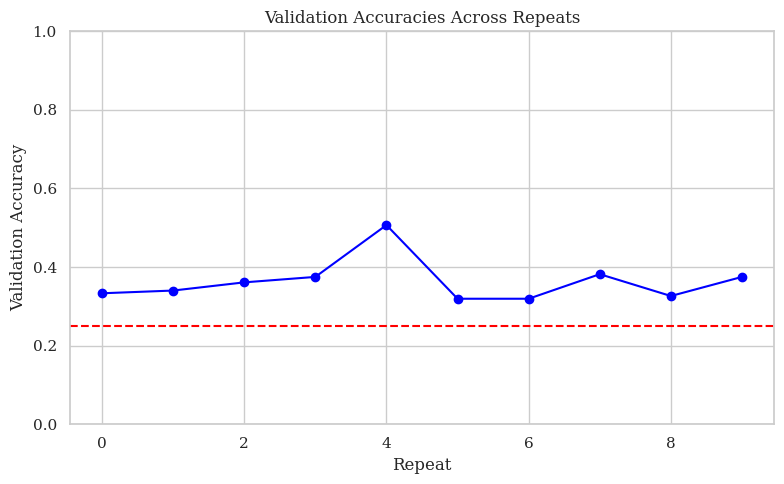

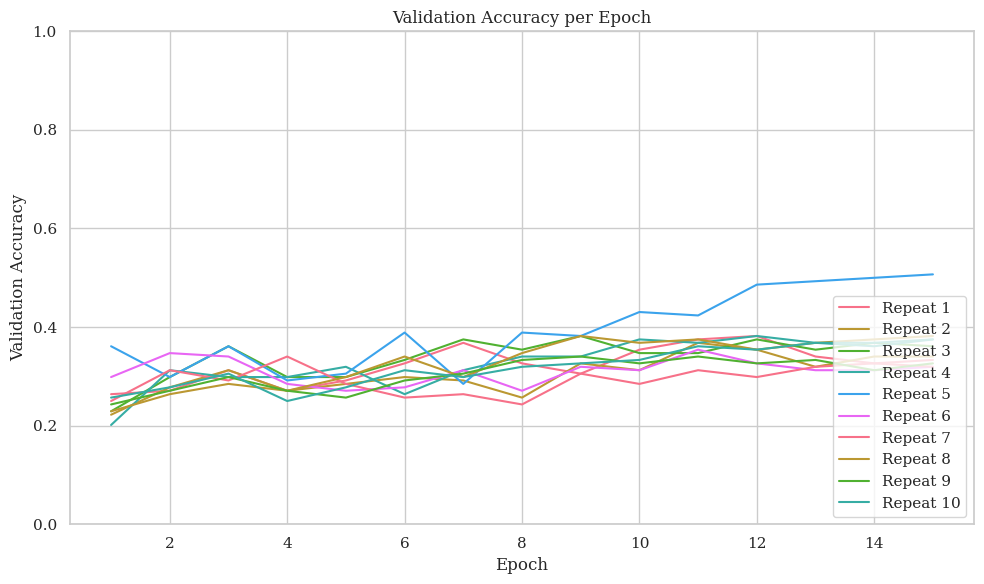

In [23]:
accuracies = results['all_accuracies']
histories = results['all_histories']
epochs = experiment.epochs

# plot validation accuracies across repeats
plt.figure(figsize=(8, 5))
plt.plot(accuracies, marker='o', linestyle='-', color='blue')
plt.axhline(chance_level, color='red', linestyle='--', label='Chance Level (25%)')
plt.title('Validation Accuracies Across Repeats')
plt.xlabel('Repeat')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot validation accuracies over epochs for each repeat
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history[:, 'epoch'], history[:, 'valid_accuracy'], label=f'Repeat {i+1}')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# for fixed hyperparameters across datasets
def run_experiments(learning_rate, batch_size, repeats = 10, epochs = 15):
    val_accuracies = []
    epochs_to_best = []
    all_histories = []

    for i in range(repeats):
        print(f"\nRun {i+1}/{repeats}")
        set_random_seeds(seed = 2025 + i, cuda = torch.cuda.is_available())

        data_dirs = ['/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data1', '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data2', '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/weibo_data3']
        dataset = WeiboDataset(data_dirs)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])

        X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

        train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
        valid_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

        n_classes = 4
        n_chans = X_train.shape[1]
        input_time_length = X_train.shape[2]
        print(input_time_length)

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length = 'auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion = torch.nn.CrossEntropyLoss,
            optimizer = torch.optim.AdamW,
            optimizer__lr = learning_rate,
            train_split = predefined_split(valid_dataset),
            batch_size = batch_size,
            callbacks = ['accuracy'],
            device = 'cuda' if torch.cuda.is_available() else 'cpu',
            classes = list(range(4))
        )

        clf.fit(train_dataset, y = None, epochs = epochs)

        best_epoch = int(np.argmax(clf.history[:, 'valid_accuracy']))
        best_acc = float(clf.history[best_epoch, 'valid_accuracy'])
        val_accuracies.append(best_acc)
        epochs_to_best.append(best_epoch)
        all_histories.append(clf.history)

    return val_accuracies, epochs_to_best, all_histories


In [18]:
# run training
learning_rate = 0.00075
batch_size = 40

accuracies, epochs_needed, histories = run_experiments(learning_rate, batch_size, repeats = 10)


Run 1/10
Final dataset size: (720, 64, 1600), Labels shape: (720,)
1600


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3628        2.6417       0.2639            0.2639        2.3425  6.0540
      2            0.3594        2.5910       0.2431            0.2431        2.0627  5.8478
      3            0.4288        2.0632       0.2847            0.2847        1.9138  5.4636
      4            0.4462        1.9000       0.2292            0.2292        1.8264  6.3041
      5            0.5278        1.7117       0.3125            0.3125        1.7077  5.5632
      6            0.5069        1.5503       0.3333            0.3333        1.6233  5.8359
      7            0.6181        1.6038       0.3611            0.3611        1.6255  5.9286
      8            0.5799        1.4029       0.3472            0.3472        1.6290  5.6429
      9            0.6562        1.3140       0.3750            0.3750

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3385        2.7585       0.2431            0.2431        2.2458  6.5966
      2            0.4080        2.2147       0.2639            0.2639        2.1374  5.5581
      3            0.4583        1.9520       0.2639            0.2639        1.7746  6.0339
      4            0.4462        1.7787       0.2431            0.2431        1.8726  5.9600
      5            0.5347        1.6699       0.3125            0.3125        1.7565  5.7898
      6            0.5764        1.5954       0.2986            0.2986        1.7599  5.7414
      7            0.5833        1.4170       0.3194            0.3194        1.7662  6.2175
      8            0.5903        1.4855       0.2986            0.2986        1.8600  5.9409
      9            0.5955        1.3032       0.2986            0.2986

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3715        2.9140       0.2847            0.2847        2.1112  5.5564
      2            0.3993        2.3088       0.3056            0.3056        1.8310  5.5792
      3            0.4878        2.0649       0.3542            0.3542        1.5582  5.4566
      4            0.4653        1.7876       0.2778            0.2778        1.7179  5.4688
      5            0.5434        1.7054       0.3333            0.3333        1.5713  5.5076
      6            0.5660        1.6047       0.3681            0.3681        1.4875  5.4526
      7            0.5833        1.5125       0.3750            0.3750        1.5386  5.4389
      8            0.6372        1.4230       0.3472            0.3472        1.4633  5.5061
      9            0.6250        1.3318       0.3125            0.3125

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3750        2.8280       0.2500            0.2500        2.0865  5.6569
      2            0.4358        2.4619       0.2917            0.2917        1.7196  5.4400
      3            0.4549        2.1227       0.3125            0.3125        1.7351  5.5006
      4            0.5174        1.7618       0.3194            0.3194        1.6430  5.4066
      5            0.5712        1.7807       0.3194            0.3194        1.6185  5.4266
      6            0.5729        1.6534       0.3194            0.3194        1.5251  5.4769
      7            0.5764        1.5393       0.3194            0.3194        1.6006  5.5153
      8            0.6424        1.4376       0.2778            0.2778        1.6001  5.5386
      9            0.6632        1.3356       0.3333            0.3333

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3559        3.0110       0.2847            0.2847        1.7414  5.5176
      2            0.4097        2.2856       0.3056            0.3056        1.8501  5.4790
      3            0.3663        2.0402       0.2986            0.2986        1.9258  5.5801
      4            0.4514        1.9611       0.3333            0.3333        1.6274  5.5031
      5            0.4653        1.6772       0.3750            0.3750        1.7010  5.5072
      6            0.5069        1.5940       0.3194            0.3194        1.6510  5.4673
      7            0.5833        1.5691       0.4236            0.4236        1.5429  5.5119
      8            0.5243        1.5489       0.3125            0.3125        1.7771  5.4499
      9            0.6354        1.3675       0.3750            0.3750

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3663        2.8574       0.2986            0.2986        2.2782  6.2778
      2            0.4045        2.2724       0.4097            0.4097        1.8323  5.6695
      3            0.4583        1.9099       0.3264            0.3264        1.7809  5.6416
      4            0.4878        1.9034       0.2986            0.2986        1.6426  5.6426
      5            0.5122        1.5985       0.3611            0.3611        1.5162  5.7408
      6            0.5694        1.6248       0.3542            0.3542        1.5148  5.8119
      7            0.5729        1.5898       0.3264            0.3264        1.6190  5.7455
      8            0.5990        1.3755       0.3542            0.3542        1.5480  5.5934
      9            0.6163        1.3794       0.3264            0.3264

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3576        2.9378       0.2222            0.2222        2.5314  5.8477
      2            0.4306        2.3495       0.2778            0.2778        1.8438  5.5366
      3            0.3941        2.0941       0.3264            0.3264        1.6860  5.7402
      4            0.4253        1.7754       0.2639            0.2639        1.8542  5.4602
      5            0.5451        1.7529       0.2986            0.2986        1.6615  5.6502
      6            0.4931        1.6239       0.3125            0.3125        1.7754  5.5797
      7            0.5538        1.5884       0.2917            0.2917        1.6872  5.5971
      8            0.6094        1.4804       0.2778            0.2778        1.5558  5.9045
      9            0.6545        1.3888       0.3056            0.3056

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3958        2.8261       0.2083            0.2083        2.0009  6.0195
      2            0.3941        2.1882       0.2917            0.2917        1.6869  5.4667
      3            0.4601        1.9629       0.2639            0.2639        1.7160  5.5980
      4            0.4601        1.8224       0.2917            0.2917        1.8021  5.6560
      5            0.5417        1.8015       0.2500            0.2500        1.7856  5.9749
      6            0.5260        1.5290       0.2847            0.2847        1.8628  5.7075
      7            0.5312        1.5735       0.2986            0.2986        1.9096  5.7822
      8            0.6319        1.3150       0.3403            0.3403        1.7099  5.6165
      9            0.6215        1.2551       0.2847            0.2847

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3316        2.9802       0.2361            0.2361        2.4015  5.7774
      2            0.4253        2.4246       0.2083            0.2083        1.8650  6.3525
      3            0.4028        2.1109       0.3125            0.3125        1.8224  5.9964
      4            0.4826        1.9290       0.2986            0.2986        1.6386  5.7912
      5            0.5104        1.7061       0.3472            0.3472        1.5722  5.6746
      6            0.5017        1.6629       0.3194            0.3194        1.7196  5.6959
      7            0.5469        1.5632       0.3056            0.3056        1.6087  5.9629
      8            0.5833        1.5057       0.3194            0.3194        1.6313  5.7762
      9            0.5885        1.4455       0.3681            0.3681

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3559        2.7753       0.2847            0.2847        1.8783  5.7279
      2            0.3594        2.6184       0.2569            0.2569        2.0698  6.0889
      3            0.4427        1.8905       0.3125            0.3125        1.8740  5.5515
      4            0.5122        1.8825       0.2986            0.2986        1.6341  6.1027
      5            0.5469        1.6742       0.2431            0.2431        1.7050  5.7724
      6            0.5851        1.5880       0.3056            0.3056        1.7646  6.0828
      7            0.5833        1.4851       0.2708            0.2708        1.7450  5.6301
      8            0.5642        1.4379       0.3056            0.3056        1.7377  5.4952
      9            0.5816        1.2933       0.3056            0.3056

In [19]:
# run t-tests
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 10.3237, p: 0.0000


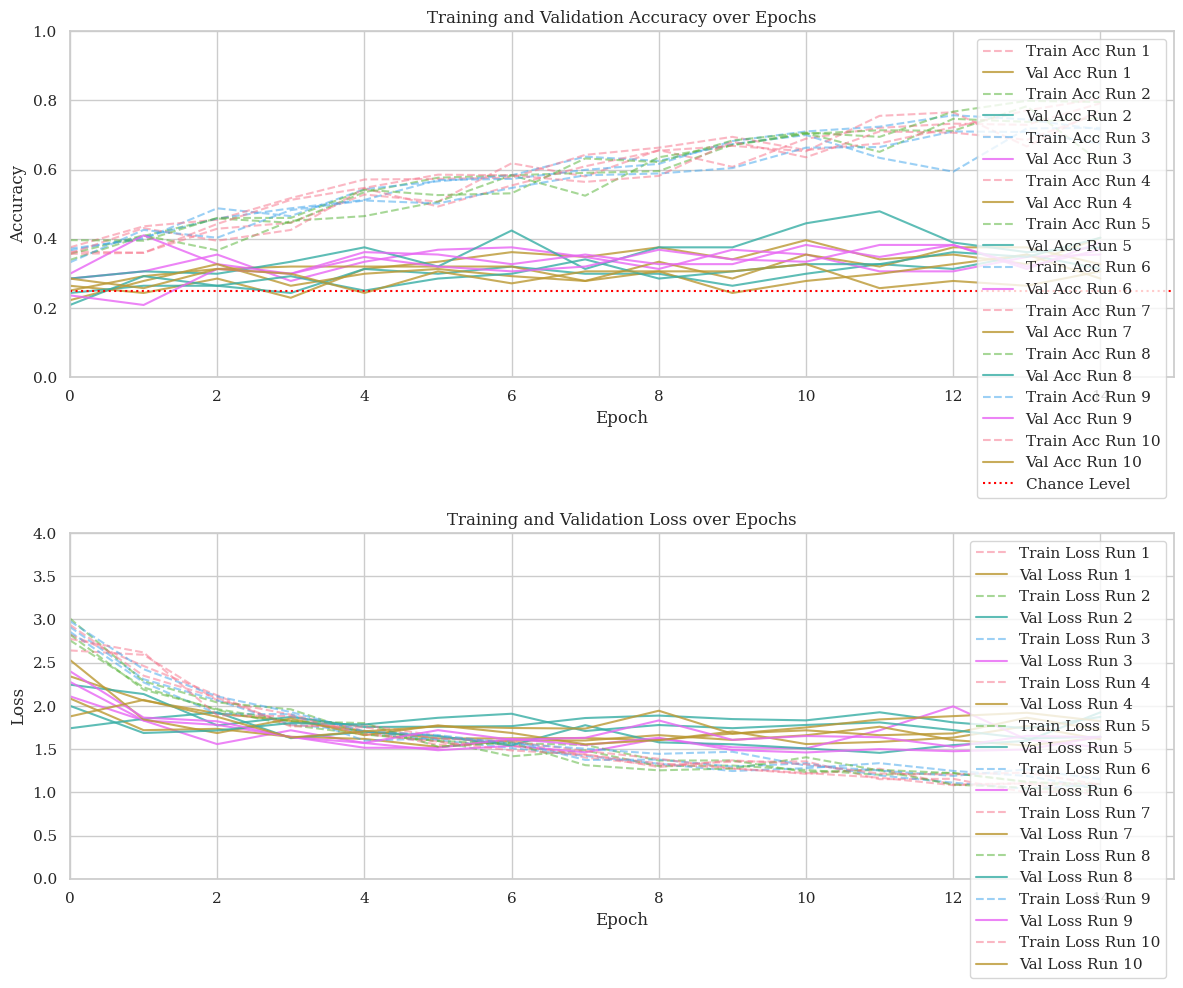

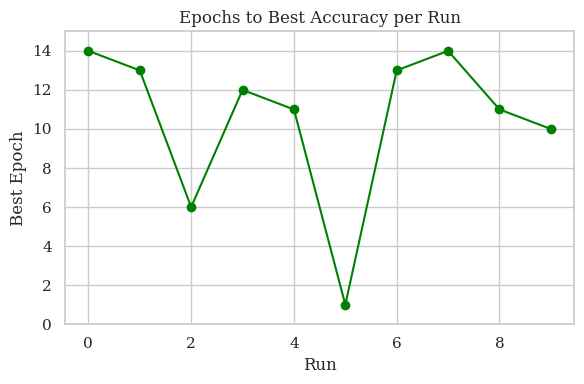

In [21]:
# plot results
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

num_epochs = 15

for i, hist in enumerate(histories):
    axs[0].plot(hist[:, 'train_accuracy'], linestyle='--', alpha=0.5, label=f'Train Acc Run {i + 1}')
    axs[0].plot(hist[:, 'valid_accuracy'], alpha=0.8, label=f'Val Acc Run {i + 1}')
    axs[1].plot(hist[:, 'train_loss'], linestyle='--', alpha=0.5, label=f'Train Loss Run {i + 1}')
    axs[1].plot(hist[:, 'valid_loss'], alpha=0.8, label=f'Val Loss Run {i + 1}')

# plot accuracy per repeat
axs[0].axhline(y=chance_level, color='r', linestyle=':', label='Chance Level')
axs[0].set_title('Training and Validation Accuracy over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, num_epochs)
axs[0].legend()
axs[0].grid(True)

# plot loss per repeat
axs[1].set_title('Training and Validation Loss over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0, 4)
axs[1].set_xlim(0, num_epochs)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# epochs to best accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_needed, marker='o', color='green')
plt.title('Epochs to Best Accuracy per Run')
plt.xlabel('Run')
plt.ylabel('Best Epoch')
plt.ylim(0, num_epochs)
plt.grid(True)
plt.tight_layout()
plt.show()